In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import numpy as np

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM, BatchNormalization
from tensorflow.keras import backend as K, callbacks
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.metrics import accuracy_score as accuracy, f1_score, mean_absolute_error as mae, mean_squared_error as mse

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set_theme()

In [4]:
def load_data(file):
    df=pd.read_csv(file,index_col='Date')
    return df

def create_sequences(data, targets, seq_len = 60):
    sequences = []
    sequences_targets = []
    for i in range(len(data) - seq_len +1):
        seq_data = data[i:i+seq_len]
        seq_target = targets[i+seq_len-1]

        sequences.append(seq_data)
        sequences_targets.append(seq_target)
    sequences = np.array(sequences)
    sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], sequences.shape[2], 1)
    return np.array(sequences), np.array(sequences_targets)

def load_datasplits(index, seq_len = 60):

    data = load_data(f'Dataset/{index}.csv')
    del data['Name']
    data = data.iloc[200:]
    data.fillna(0, inplace = True)
    targets =( (data['Close'] / data['Close'].shift(-1)) -1 )*100
    data = data[:-1]
    targets = targets[:-1]
    train_val_data = data.loc[:'2016-04-20']
    train__val_targets = targets.loc[:'2016-04-20']

    split = int(0.75*train_val_data.shape[0])
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_val_data[:split])
    train_targets = train__val_targets[:split]

    val_data = scaler.transform(train_val_data[split-seq_len:])
    val_targets = train__val_targets[split-seq_len:]

    test_data = scaler.transform(data.loc['2016-04-21':])
    test_targets = targets.loc['2016-04-21':]


    return train_data, train_targets, val_data, val_targets, test_data, test_targets

In [5]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_pred = tf.where(y_pred>=0,1,0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.where(y_true>=0,1,0)
    y_true = tf.cast(y_true, tf.float32)

    precision_pos = precision(y_true, y_pred)
    recall_pos = recall(y_true, y_pred)
    precision_neg = precision((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    recall_neg = recall((K.ones_like(y_true) - y_true), (K.ones_like(y_pred) - K.clip(y_pred, 0, 1)))
    f_posit = 2 * ((precision_pos * recall_pos) / (precision_pos + recall_pos + K.epsilon()))
    f_neg = 2 * ((precision_neg * recall_neg) / (precision_neg + recall_neg + K.epsilon()))

    return (f_posit + f_neg) / 2

In [6]:
def f1_eval(target,prediction):
    prediction = np.where(prediction>=0,1,0)
    target = np.where(target>=0,1,0)
    return f1_score(target,prediction,average='macro')


In [148]:
def getResult(models, train, train_targ, val, val_targ,test,test_targ):
    df_res = pd.DataFrame()
    mae_list_train = []
    f1_list_train  = []
    mae_list_val = []
    f1_list_val = []
    mae_list_test = []
    f1_list_test = []
    for model in models:
        prediction = model.predict(train)
        mae_list_train.append(mae(prediction,train_targ))
        f1_list_train.append(f1_eval(train_targ,prediction))

        prediction = model.predict(val)
        mae_list_val.append(mae(prediction,val_targ))
        f1_list_val.append(f1_eval(val_targ,prediction))

        prediction = model.predict(test)
        mae_list_test.append(mae(prediction,test_targ))
        f1_list_test.append(f1_eval(test_targ,prediction))

    df_res['MAE Train'] = mae_list_train
    df_res['f1 Train'] = f1_list_train

    df_res['MAE Val'] = mae_list_val
    df_res['f1 val'] = f1_list_val

    df_res['MAE Test'] = mae_list_test
    df_res['f1 test'] = f1_list_test
    return df_res

In [149]:
def plot_training(history):
    fig, ax = plt.subplots(1,2, figsize = (18,6))

    ax[0].plot(history.history['val_loss'],label='Validation')
    ax[0].plot(history.history['loss'],label='Train')
    ax[0].set(xlabel = "Epoch", ylabel = "Loss")
    ax[0].legend()

    ax[1].plot(history.history['val_f1'],label='Validation')
    ax[1].plot(history.history['f1'],label='Train')
    ax[1].set(xlabel = "Epoch", ylabel = "F1 score")
    ax[1].legend()


def plot_predictions(model, train, train_targ, val, val_targ, test, test_targ):
    train_predictions = model.predict(train)
    val_predictions = model.predict(val)
    test_predictions = model.predict(test)

    fig, axs = plt.subplots(2,3, figsize = (19,12))

    axs[0][0].scatter(train_targ, train_predictions, alpha = 0.5)
    axs[0][1].scatter(val_targ, val_predictions, alpha = 0.5)
    axs[0][2].scatter(test_targ, test_predictions, alpha = 0.5)


    for ax, title in zip(axs[0], ['Train', 'Validation', 'Test']):
        ax.set(xlabel = 'Target value', ylabel = 'Predicted value')
        ax.plot([0, 1], [0, 1], transform = ax.transAxes)
        ax.set_title(title)
    fig.suptitle("Prediction vs Targets")


    axs[1][0].hist((train_targ - train_predictions.reshape(train_targ.shape)), bins = 20, density = True)
    axs[1][1].hist((val_targ - val_predictions.reshape(val_targ.shape)), bins = 20, density = True)
    axs[1][2].hist((test_targ - test_predictions.reshape(test_targ.shape)), bins = 20, density = True)
   
    for ax, title in zip(axs[1], [f"{x} - Density of residuals" for x in ['Train', 'Validation' , 'Test']]):
        ax.set_title(title)



In [150]:
def train_model_1(train_seq, train_target, val_seq, val_target, epochs = 5, dropout_rate = 0.1, verbose = 1):
    model = Sequential()
    #1st layer
    model.add(
        Conv2D(
            filters = 32,
            kernel_size = (1, train_seq.shape[2]),
            activation='relu', 
            input_shape=(train_seq.shape[1], train_seq.shape[2], 1),
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
        )
    )
    model.add(
        MaxPool2D(pool_size = (1,1))
    )

    model.add(Reshape((-1,32)))

    model.add(LSTM(64,kernel_regularizer=tf.keras.regularizers.l2( l=0.01)))
    model.add(BatchNormalization())
    #model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, 
            activation='linear', 
            kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
            ))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mae', metrics=[f1])

    #best_model = callbacks.ModelCheckpoint('test.h5', 
    #                                        monitor='val_acc', 
    #                                        verbose=0, 
    #                                        save_best_only=True,
    #                                        save_weights_only=False, 
    #                                        mode='max', 
    #                                        save_freq =1)
    history = model.fit(train_seq, 
                    train_target, 
                    epochs=epochs, 
                    batch_size=128, 
                    verbose=verbose,
                    validation_data=(val_seq, val_target), 
                    #callbacks=[best_model]
                    )

    return model, history


In [151]:
def train_and_test(dataset,train_model, runs = 20):
    train_data, train_targets, val_data, val_targets, test_data, test_targets = load_datasplits(dataset)

    train, train_targ = create_sequences(train_data, train_targets)
    val, val_targ = create_sequences(val_data, val_targets)
    test, test_targ = create_sequences(test_data, test_targets)
    
    models =[]
    histories = []
    for _ in tqdm(range(runs)):
        model, history = train_model(train, train_targ, val, val_targ, epochs = 200, dropout_rate = 0.15, verbose = 0)
        models.append(model)
        histories.append(history)
    
    plot_predictions(model, train, train_targ, val, val_targ, test, test_targ)
    plot_training(history)
    return getResult(models,train, train_targ, val, val_targ,test, test_targ ), histories, models

100%|██████████| 1/1 [01:23<00:00, 83.40s/it]


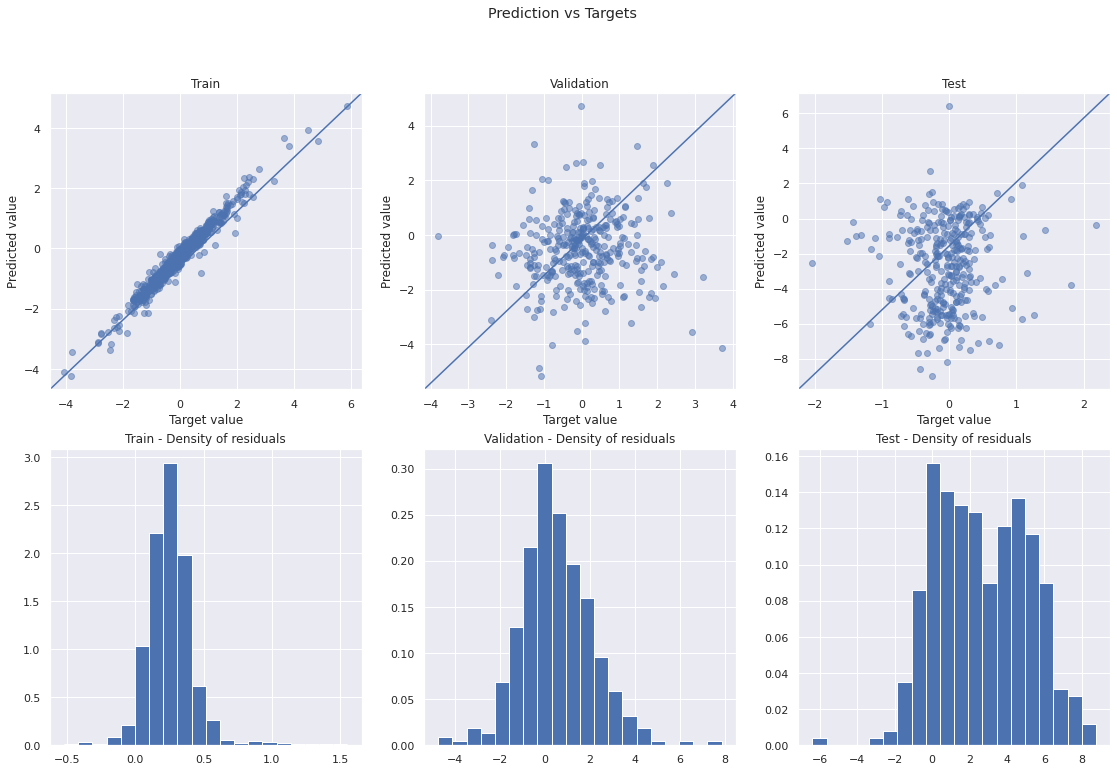

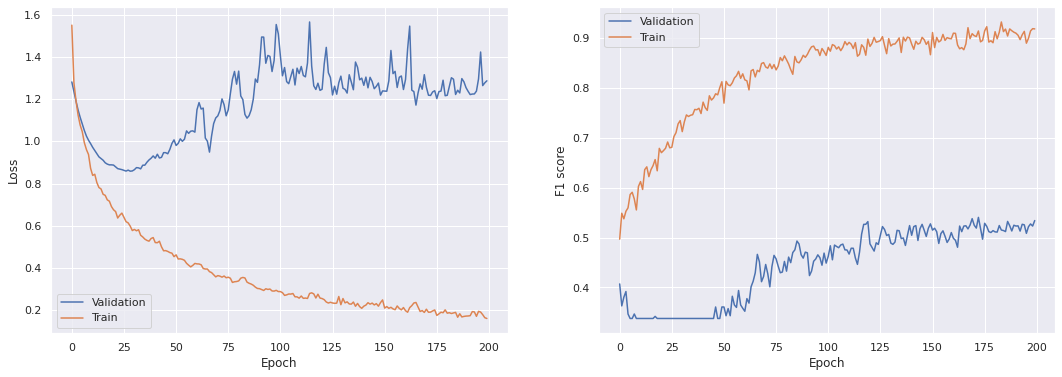

In [152]:
results_dji, _, _ = train_and_test('Processed_DJI',train_model_1,1)

In [68]:
results_dji

,MAE Train,f1 Train,MAE Val,f1 val,MAE Test,f1 test
0,0.166506,0.906466,1.172835,0.532054,2.237876,0.439695


In [15]:
def train_model_2(train_seq, train_target, val_seq, val_target, epochs = 5, dropout_rate = 0.1, verbose = 1):
    model = Sequential()
    #1st layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (1, train_seq.shape[2]),
            activation='relu', 
            input_shape=(train_seq.shape[1], train_seq.shape[2], 1),
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
        )
    )
    #2nd layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (3,1),
            activation = 'relu',
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.004)
        )
    )
    model.add(
        MaxPool2D(pool_size = (2,1))
    )

    #3rd layer
    model.add(
        Conv2D(
            filters = 8,
            kernel_size = (3,1),
            activation = 'relu',
            #kernel_regularizer =tf.keras.regularizers.l2( l=0.004)
        )
    )
    model.add(
        MaxPool2D(pool_size = (2,1))
    )


    model.add(Flatten())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, 
              activation='linear', 
              kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
              ))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mae',  metrics=[f1])

    #best_model = callbacks.ModelCheckpoint('test.h5', 
    #                                        monitor='val_acc', 
    #                                        verbose=0, 
    #                                        save_best_only=True,
    #                                        save_weights_only=False, 
    #                                        mode='max', 
    #                                        save_freq =1)
    history = model.fit(train_seq, 
                    train_target, 
                    epochs=epochs, 
                    batch_size=128, 
                    verbose=verbose,
                    validation_data=(val_seq, val_target), 
                    #callbacks=[best_model]
                    )

    return model, history

100%|██████████| 1/1 [00:24<00:00, 24.75s/it]


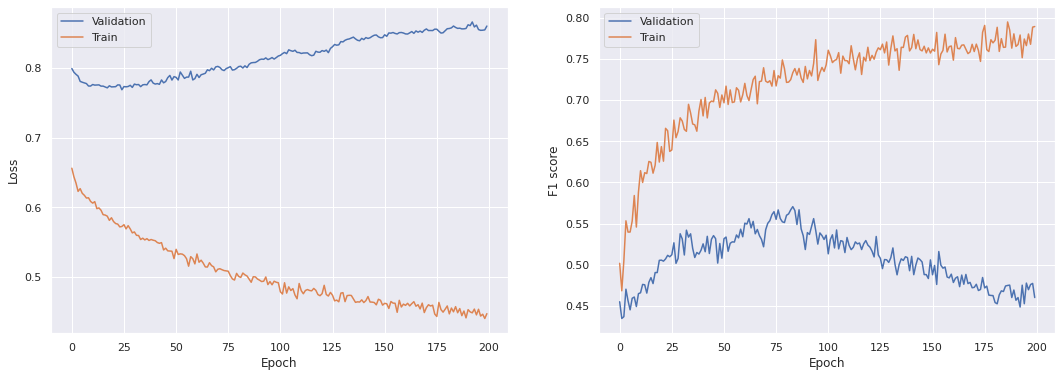

In [46]:
results_dji, _ = train_and_test('Processed_DJI',train_model_2,1)

In [47]:
results_dji

,MAE Train,f1 Train,MAE Val,f1 val,MAE Test,f1 test
0,0.384975,0.810303,0.84568,0.464185,0.441225,0.480607


In [1]:
def train_model_3(train_seq, train_target, val_seq, val_target, epochs = 5, dropout_rate = 0.1, verbose = 1):
    model = Sequential()
    model.add(Reshape((train_seq.shape[1], train_seq.shape[2])))

    model.add(LSTM(60, kernel_regularizer=tf.keras.regularizers.l2( l=0.01),dropout=0.1))
    #model.add(Dropout(dropout_rate))

    model.add(Dense(1, 
              activation='linear', 
              kernel_regularizer =tf.keras.regularizers.l2( l=0.01)
              ))


    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mae', metrics=[f1])

    #best_model = callbacks.ModelCheckpoint('test.h5', 
    #                                        monitor='val_acc', 
    #                                        verbose=0, 
    #                                        save_best_only=True,
    #                                        save_weights_only=False, 
    #                                        mode='max', 
    #                                        save_freq =1)
    history = model.fit(train_seq, 
                    train_target, 
                    epochs=epochs, 
                    batch_size=128, 
                    verbose=verbose,
                    validation_data=(val_seq, val_target), 
                    #callbacks=[best_model]
                    )

    return model, history

100%|██████████| 1/1 [01:23<00:00, 83.59s/it]


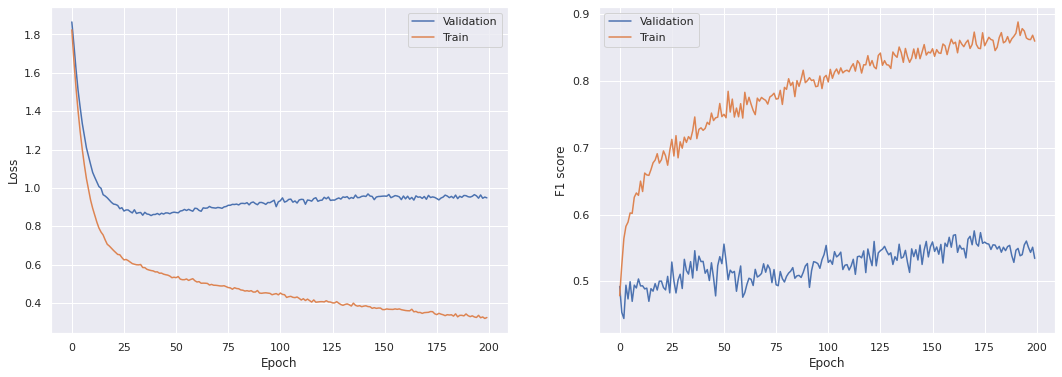

In [12]:
results_dji, _, models = train_and_test('Processed_DJI',train_model_3,1)

In [67]:
train_data, train_targets, val_data, val_targets, test_data, test_targets = load_datasplits('Processed_DJI')
test, test_targ = create_sequences(test_data, test_targets) 
train, train_targ = create_sequences(train_data, train_targets)
val, val_targ = create_sequences(val_data, val_targets)

In [137]:
model = models[0]



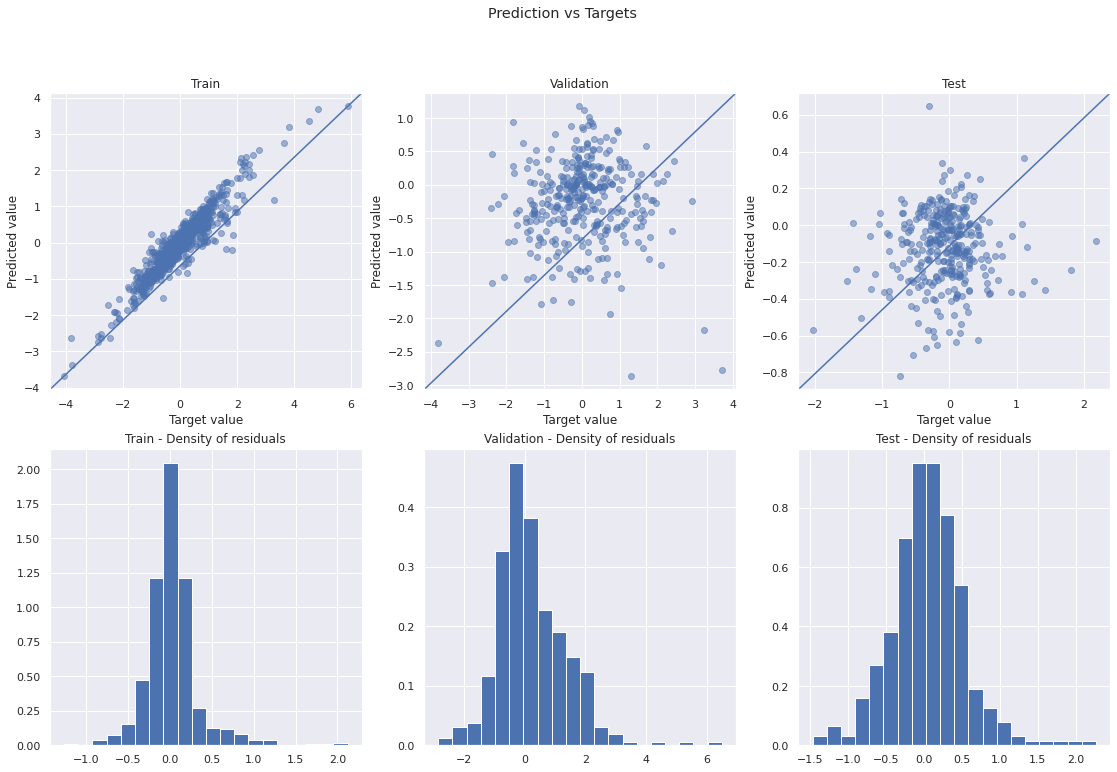

In [138]:
plot_predictions(model, train, train_targ, val, val_targ, test, test_targ)


(980,)